In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Activation Functions
def sigmoid(X):
    A = 1/(1+np.exp(-X))
    return A

def relu(X):
    A = np.maximum(0,X)
    return A

def relu_grad(dA,A):
    dX = np.array(dA, copy=True)
    dX[A<=0] = 0
    return dX

def sigmoid_grad(dA,A):
    dX = dA * A* (1-A)
    return dX

def softmax(X):
    A=np.exp(X)
    A = A/np.sum(A, axis=0, keepdims=True)
    return A

def act_fn(X,activation):
    if activation == "sigmoid":
        return sigmoid(X) 

    elif activation == "relu":
        return relu(X)

    elif activation == "softmax":
        return softmax(X)
    else:
        print("Please include the fn first")
            
def act_fn_grad(dA, A, activation_name):
    # Returns dX
    if activation_name == "relu":
        return relu_grad(dA, A)

    elif activation_name == "sigmoid":
        return sigmoid_grad(dA, A)

In [3]:
def class_onehot(indices, num_classes , zero_indexed=True): # Takes class number [0,classes-1] and returns one hot (zero indexed)
    if zero_indexed:
        return np.identity(num_classes)[np.array(indices)].T
    else :
        return np.identity(num_classes)[np.array(indices-1)].T

In [4]:
# Loss Functions
def cross_entropy_sigmoid(y, y_pred):
    m = Y.shape[1]
    cost = -1 / m * np.sum(y * np.log(y_pred) + (1-y) * np.log(1-y_pred))
    cost = np.squeeze(cost)
    return cost

def cross_entropy_sigmoid_grad(y, y_pred):
    m = y.shape[1]
    return -(np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred))

def mean_squared(y, y_pred):
    return  np.sum((y - y_pred)**2 ).squeeze() / (y_pred.shape[1]*2)

def mean_squared_grad(y, y_pred):
    return (y_pred - y)

def cross_entropy_softmax(y,y_pred,one_hot=False,zero_indexed_classes=True, classes=1):
    if one_hot:
        return np.sum(np.array(y)*(-1*np.log(y_pred)))
    else:
        # classes should begin with zero index or else change one_hot_fn
        return np.sum(class_onehot(y,classes,zero_indexed=zero_indexed_classes)*(-1*np.log(y_pred)))

def cross_entropy_softmax_grad(y,y_pred,one_hot=False,zero_indexed_classes=True, classes=1):
    if one_hot:
        return np.array(y)*(-1/y_pred)
    else:
        # classes should begin with zero index or else change one_hot_fn
        return class_onehot(y,classes,zero_indexed=zero_indexed_classes)*(-1/y_pred)

In [5]:
def cost_fn(y,y_pred, output_activation="sigmoid", loss_fn="cross_entropy"):
    if output_activation=="sigmoid" and loss_fn=="cross_entropy":
        return cross_entropy_sigmoid(y, y_pred)
    elif output_activation=="softmax" and loss_fn=="cross_entropy":
        return cross_entropy_softmax(y,y_pred)
    elif output_activation=="linear" and loss_fn=="mse":
        return mean_squared(y, y_pred)

In [6]:
def output_exc_act_grad(y,y_pred, output_activation="sigmoid", loss_fn="cross_entropy", classes=1):
    if output_activation=="sigmoid" and loss_fn=="cross_entropy":
        return y_pred-y
    elif output_activation=="softmax" and loss_fn=="cross_entropy":
        y=class_onehot(y,classes)
        return y_pred-y 
    elif output_activation=="linear" and loss_fn=="mse":
        return y - y_pred

In [7]:
class FeedForward_NN:
    def __init__(self, input_features, hidden_layers_dims=[2], output_nodes=1):

        self.hL = len(hidden_layers_dims)
        self.output_nodes = output_nodes
        self.layer_dims = [input_features] + hidden_layers_dims + [output_nodes] # list with all layer sizes (including input and output)
        
        ## Weight Initialization
        self.params = {}
        L = len(self.layer_dims) # total number of layers in the network

        for l in range(1, L):
            self.params['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * 0.01
            self.params['b' + str(l)] = np.zeros((self.layer_dims[l], 1))
        
        self.L = len(self.params) // 2 # number of layers in the neural network
        self.caches=[] # stores tuple of X_W (W, X) and activation cache for each layer
        self.grads = {} # it is storing all the partial derivatives i.e. dX, db and dW
        
    
    def forward_prop(self, X):
     
        self.caches.clear() # self.caches stores tuple of X_W and activation cache for each layer
        
        for l in range(1, self.L):
            W = self.params['W%d' % l]
            b = self.params['b%d' % l]
            
            self.caches.append(X)
            X = np.dot(W , X) + b
            A = act_fn(X,'relu')
            
            X = A # current activation will act as input for next layer
        
        self.caches.append(X)
        ## last layer activation and cache done seperately because different activation functions used
        W = self.params['W%d' % self.L]
        b = self.params['b%d' % self.L]
        
        X = np.dot(W , X) + b
        return X
    
    
    def backward_prop(self,dX): # dX is derivaltive of loss fn wrt last layer X i.e, X = W_L @ A_L-1 + b_L
        self.grads.clear()
        m = dX.shape[1]
        
        # Now you know partial derivative of last layer activation wrt loss, calculate the weights, biases and L-1 layer activation gradients 
        A_prev = self.caches[self.L-1] # caches stores activations of all layer(last layer not required) + input
        
        W = self.params["W"+str(self.L)]
        
        self.grads["dW" + str(self.L)] = 1 / m * np.dot(dX , A_prev.T)
        self.grads["db" + str(self.L)] = 1 / m * np.sum(dX, axis=1, keepdims=True)
        self.grads["dA" + str(self.L-1)] = np.dot(W.T , dX)
        
        for l in reversed(range(self.L-1)):
            A_prev = self.caches[l]
            W = self.params["W"+str(l+1)]
            
            dX = act_fn_grad(self.grads["dA" + str(l + 1)], A_prev, 'relu') # in first iteration it is dx_L-1
                                                                            # use dX_L-1 to find dW_L-1, db_L-1 and dA_L-2
            self.grads["dW" + str(l+1)] = 1 / m * np.dot(dX , A_prev.T)
            self.grads["db" + str(l+1)] = 1 / m * np.sum(dX, axis=1, keepdims=True)
            self.grads["dA" + str(l)] = np.dot(W.T , dX)
            
    def update_parameters(self,learning_rate):
        for l in range(self.L):
            self.params["W" + str(l+1)] = self.params["W" + str(l+1)] - learning_rate * self.grads["dW" + str(l+1)]
            self.params["b" + str(l+1)] = self.params["b" + str(l+1)] - learning_rate * self.grads["db" + str(l+1)]

In [8]:
# Prior to this define the model
def train(model,X,Y,output_activation="sigmoid", output_loss_fn="cross_entropy", iterations=51, optimizer=None, learning_rate=0.0075, batch_size=None, print_cost=False):
    
    costs = []
    for i in range(iterations):

        # Forward Propagation
        XL = model.forward_prop(X)
        Y_pred = act_fn(XL,output_activation)
        #model.caches.append((X_W_cache, Y_pred))
        
        # Compute cost
        cost = cost_fn(Y,Y_pred, output_activation=output_activation, loss_fn=output_loss_fn)
        
        # Backward propagation
        Y = Y.reshape(Y_pred.shape) # True output
        
        dZ=output_exc_act_grad(Y,Y_pred,output_activation=output_activation,loss_fn=output_loss_fn,classes=model.output_nodes)
        
        model.backward_prop(dZ)
        
        # Update parameters.
        #optimizer_step(model.grads, optimizer=optimizer, learning_rate)
        model.update_parameters(learning_rate)

        # Print the cost every 100 training example
        if print_cost and i % 10 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 10 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()


### Dummy data for checking

In [12]:
X=np.array([[0,0],[0,1],[1,0],[1,1],[2,1]]).T
Y=np.array([0,1,1,0,1]).reshape(-1,1).T

In [10]:
nn=FeedForward_NN(2)

Cost after iteration 0: 0.6931739295363786
Cost after iteration 10: 0.6924350767649047
Cost after iteration 20: 0.6917234237458493
Cost after iteration 30: 0.6910379658077948
Cost after iteration 40: 0.6903777348394766
Cost after iteration 50: 0.689741798034607


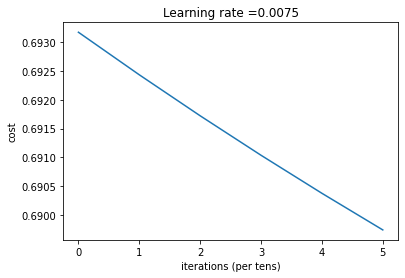

In [11]:
train(nn,X,Y,print_cost=True)